In [1]:
from ipsl_dcpp.model.ipsl_dataset import IPSL_DCPP
import torch
import lightning as pl
from ipsl_dcpp.model.pangu import PanguWeather
from hydra import compose, initialize
from omegaconf import OmegaConf
import hydra
import numpy as np
import os
work_dir = os.environ['WORK']
import xarray as xr
with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
import scipy.stats as stats



/gpfsdswork/projects/rech/mlr/udy16au/miniconda3/envs/env_gpu5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_dataloader = torch.utils.data.DataLoader(IPSL_DCPP('train',cfg.experiment.lead_time_months,surface_variables=cfg.experiment.surface_variables,depth_variables=cfg.experiment.depth_variables),batch_size=1,shuffle=False,num_workers=1)
batch = next(iter(train_dataloader))
model = hydra.utils.instantiate(
    cfg.experiment.module,
    backbone=hydra.utils.instantiate(
        cfg.experiment.backbone,
    ),
    dataset=train_dataloader.dataset
)

/gpfsdswork/projects/rech/mlr/udy16au/miniconda3/envs/env_gpu5/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [3]:
def get_power_spectral_density(data):
    #data = data[:data.shape[0], data.shape[1]//2-data.shape[0]//2:data.shape[1]//2+data.shape[0]//2]
    #have to make this square, clip the last row of lats........
    data = data[:,:data.shape[0]]
    npix = data.shape[0]
    print(npix)
    print(data.shape)
    fourier_image = np.fft.fftn(data)
    fourier_amplitudes = np.abs(fourier_image)

    kfreq = np.fft.fftfreq(npix) * npix
    kfreq2D = np.meshgrid(kfreq, kfreq)
    print(kfreq2D[0].shape)
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)

    knrm = knrm.flatten()
    fourier_amplitudes = fourier_amplitudes.flatten()

    kbins = np.arange(0.5, npix//2+1, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    print(fourier_amplitudes.shape)
    print(knrm.shape)
    print(kbins)
    Abins, _, _ = stats.binned_statistic(knrm, 
                                         fourier_amplitudes,
                                         statistic = "mean",
                                         bins = kbins)
    Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
    return kvals, Abins


143
torch.Size([143, 143])
(143, 143)
(20449,)
(20449,)
[ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
 14.5 15.5 16.5 17.5 18.5 19.5 20.5 21.5 22.5 23.5 24.5 25.5 26.5 27.5
 28.5 29.5 30.5 31.5 32.5 33.5 34.5 35.5 36.5 37.5 38.5 39.5 40.5 41.5
 42.5 43.5 44.5 45.5 46.5 47.5 48.5 49.5 50.5 51.5 52.5 53.5 54.5 55.5
 56.5 57.5 58.5 59.5 60.5 61.5 62.5 63.5 64.5 65.5 66.5 67.5 68.5 69.5
 70.5 71.5]


Text(0.5, 1.0, 'gpp')

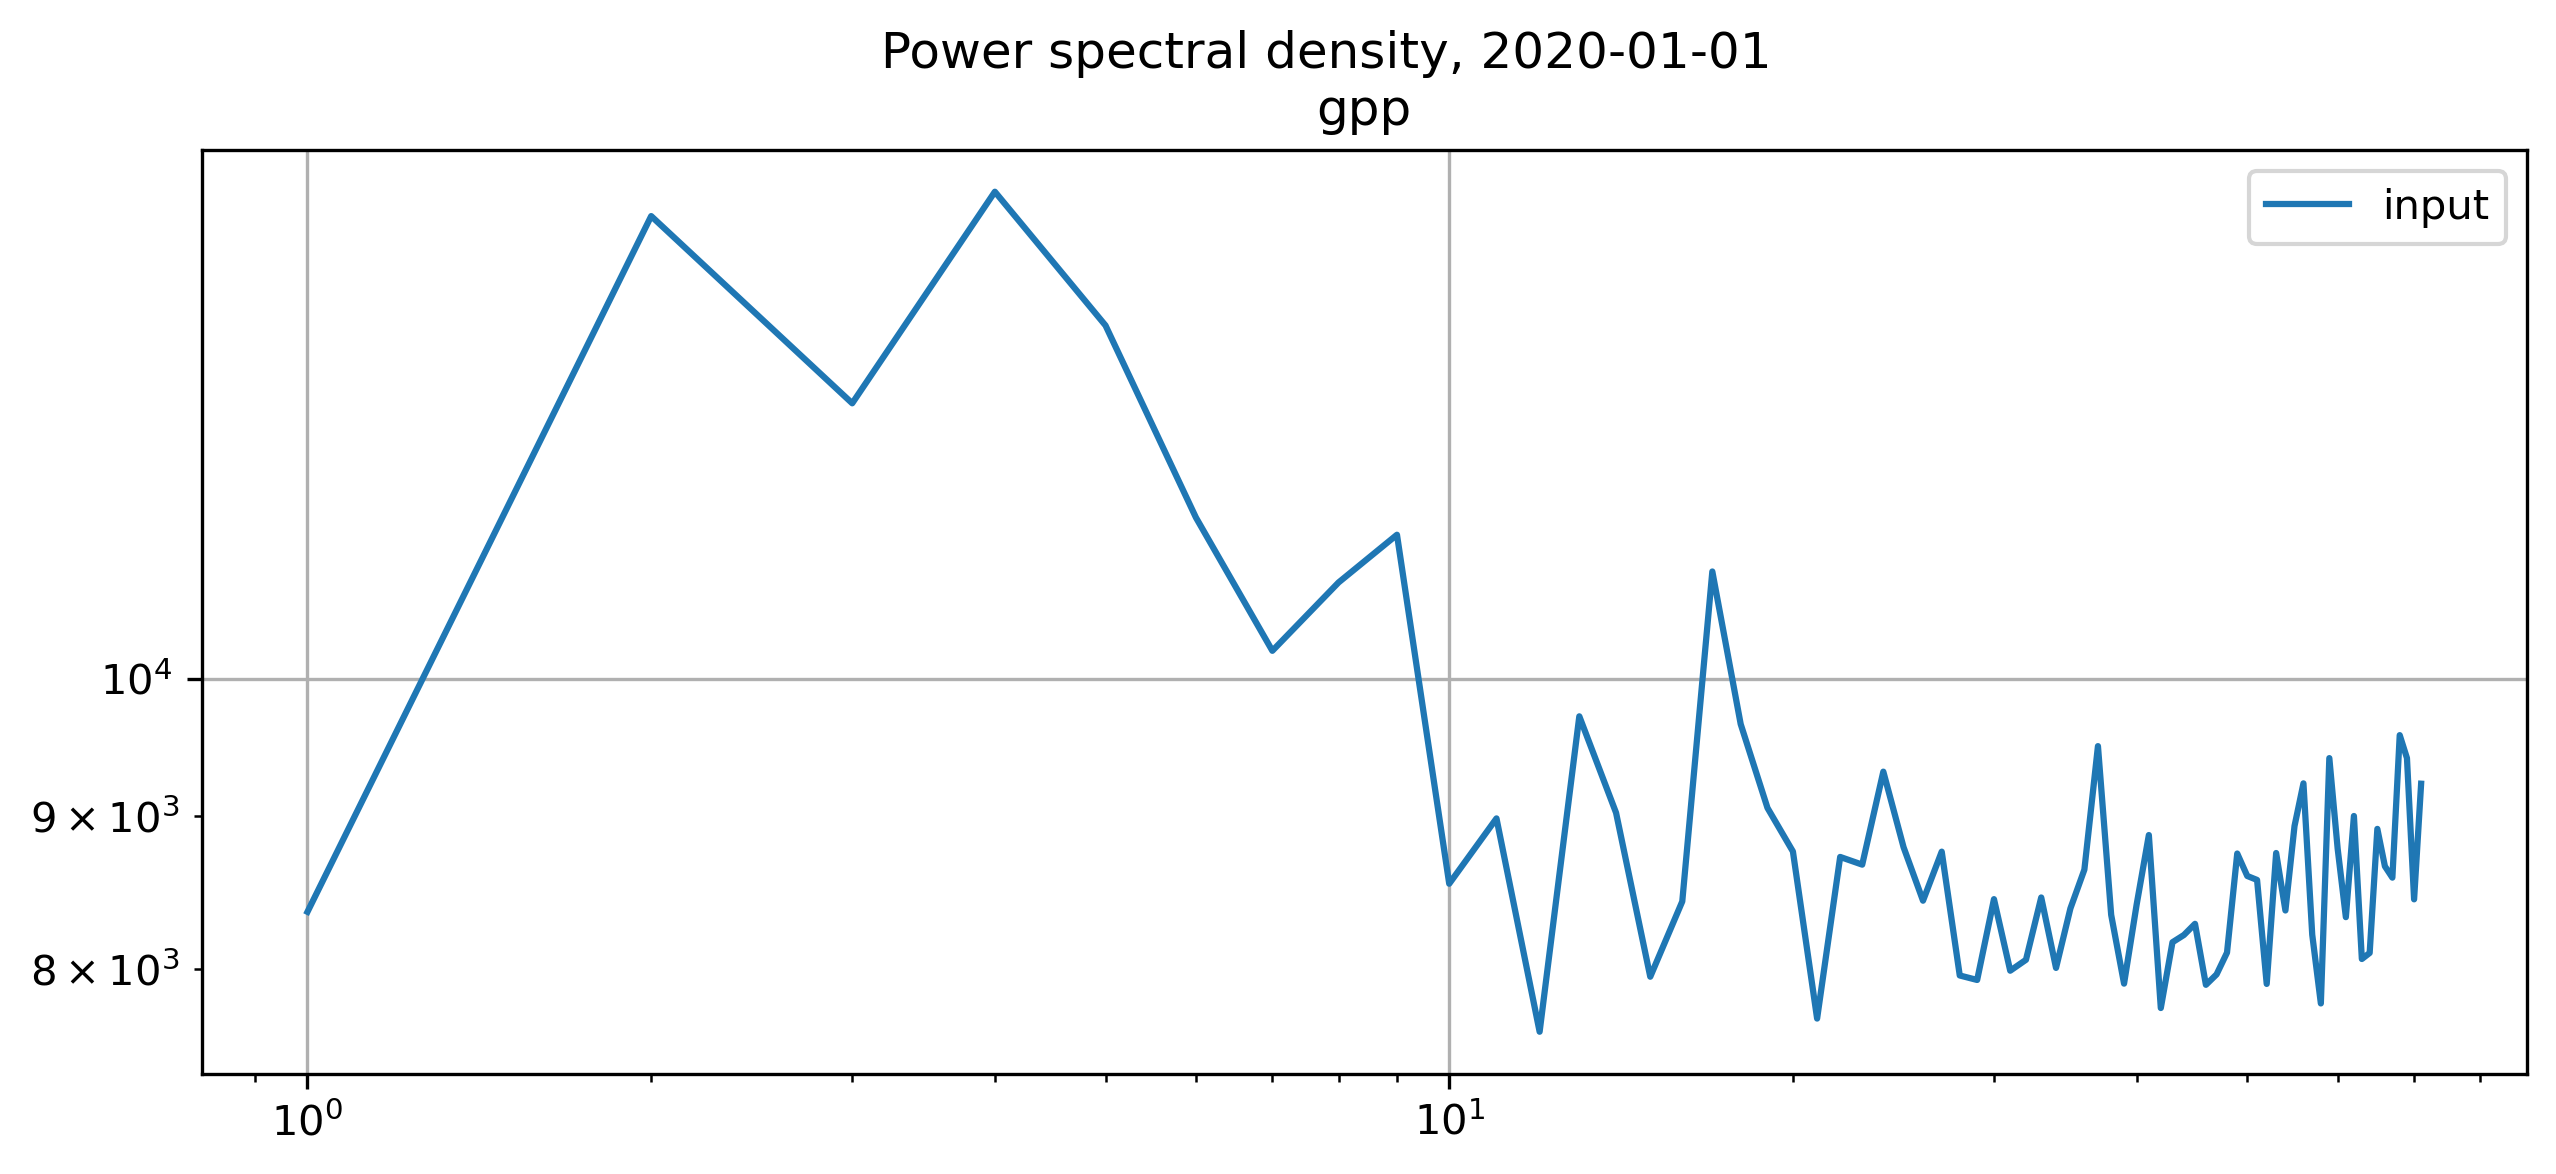

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 4), dpi=300)
fig.suptitle('Power spectral density, 2020-01-01')
var_name = 'gpp'
var_index = cfg.experiment.surface_variables.index(var_name)
logfreq1, logamp1 = get_power_spectral_density(batch['state_surface'][:,var_index].squeeze())
#logfreq2, logamp2 = get_power_spectral_density(surface_output_denorm[j])
#logfreq1, logamp1 = get_power_spectral_density(batch['surface_variables'][0, j, 0])
#logfreq2, logamp2 = get_power_spectral_density(coeff*output['surface_variables'][0, j, 0])
ax.loglog(logfreq1, logamp1, label='input')
#axes.loglog(logfreq2, logamp2, label='output')
ax.grid()
ax.legend()
ax.set_title('gpp')


In [45]:
data = batch['state_surface'][:,var_index].squeeze()
data = data[:,:data.shape[0]]
npix = data.shape[0]
print(npix)
print(data.shape)
fourier_image = np.fft.fftn(data)
fourier_amplitudes = np.abs(fourier_image)

kfreq = np.fft.fftfreq(npix) * npix
kfreq2D = np.meshgrid(kfreq, kfreq)
print(kfreq2D[0].shape)
knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)

knrm = knrm.flatten()
fourier_amplitudes = fourier_amplitudes.flatten()

kbins = np.arange(0.5, npix//2+1, 1.)
kvals = 0.5 * (kbins[1:] + kbins[:-1])
print(fourier_amplitudes.shape)
print(knrm.shape)
print(kbins)
Abins, _, _ = stats.binned_statistic(knrm, 
                                     fourier_amplitudes,
                                     statistic = "mean",
                                     bins = kbins)
Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)

143
torch.Size([143, 143])
(143, 143)
(20449,)
(20449,)
[ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
 14.5 15.5 16.5 17.5 18.5 19.5 20.5 21.5 22.5 23.5 24.5 25.5 26.5 27.5
 28.5 29.5 30.5 31.5 32.5 33.5 34.5 35.5 36.5 37.5 38.5 39.5 40.5 41.5
 42.5 43.5 44.5 45.5 46.5 47.5 48.5 49.5 50.5 51.5 52.5 53.5 54.5 55.5
 56.5 57.5 58.5 59.5 60.5 61.5 62.5 63.5 64.5 65.5 66.5 67.5 68.5 69.5
 70.5 71.5]


In [49]:
kbins[1:]**2 - kbins[:-1]**2

array([  2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,  22.,
        24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,  44.,
        46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,  66.,
        68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,  88.,
        90.,  92.,  94.,  96.,  98., 100., 102., 104., 106., 108., 110.,
       112., 114., 116., 118., 120., 122., 124., 126., 128., 130., 132.,
       134., 136., 138., 140., 142.])

In [12]:
fourier_amplitudes.flatten()

array([1106.00630698,  634.85131144, 1066.6877248 , ...,  526.98775569,
        352.67917838,  908.6072884 ])

In [36]:
import numpy as np
npix = 143
kfreq = np.fft.fftfreq(npix) * npix
kfreq2D = np.meshgrid(kfreq, kfreq)
np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)

array([[0.        , 1.        , 2.        , ..., 3.        , 2.        ,
        1.        ],
       [1.        , 1.41421356, 2.23606798, ..., 3.16227766, 2.23606798,
        1.41421356],
       [2.        , 2.23606798, 2.82842712, ..., 3.60555128, 2.82842712,
        2.23606798],
       ...,
       [3.        , 3.16227766, 3.60555128, ..., 4.24264069, 3.60555128,
        3.16227766],
       [2.        , 2.23606798, 2.82842712, ..., 3.60555128, 2.82842712,
        2.23606798],
       [1.        , 1.41421356, 2.23606798, ..., 3.16227766, 2.23606798,
        1.41421356]])